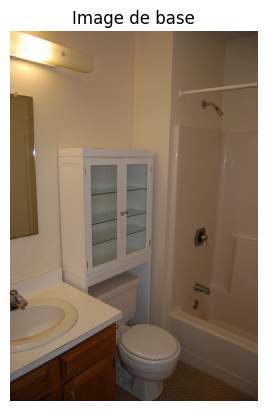

AttributeError: 'RNN_Decoder' object has no attribute 'reset_state'

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
import pickle

# Définir le chemin vers les modèles sauvegardés
model_save_path = "./saved_model2"

# Définition des classes personnalisées
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights

# Chargement des modèles
encoder = tf.keras.models.load_model(
    os.path.join(model_save_path, "encoder"),
    custom_objects={'CNN_Encoder': CNN_Encoder}
)

decoder = tf.keras.models.load_model(
    os.path.join(model_save_path, "decoder"),
    custom_objects={'RNN_Decoder': RNN_Decoder, 'BahdanauAttention': BahdanauAttention}
)

# Chargement du tokenizer
with open(os.path.join(model_save_path, "tokenizer.pickle"), 'rb') as handle:
    tokenizer = pickle.load(handle)

# Chargement des paramètres
with open(os.path.join(model_save_path, "params.pickle"), "rb") as handle:
    params = pickle.load(handle)

max_length = params["max_length"]
attention_features_shape = params["attention_features_shape"]

# Modèle InceptionV3 pour l'extraction des features des images
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    
    hidden = decoder.reset_state(batch_size=1)
    
    temp_input = tf.expand_dims(load_image(image), 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    features = encoder(img_tensor_val)
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        
        word = tokenizer.index_word.get(predicted_id, '<unk>')
        result.append(word)
        
        if word == '<end>':
            break
        
        dec_input = tf.expand_dims([predicted_id], 0)
    
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    
    fig = plt.figure(figsize=(10, 10))
    
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    
    plt.tight_layout()
    plt.show()

def generate_caption(image_path):
    # Afficher l'image de base
    temp_image = np.array(Image.open(image_path))
    plt.imshow(temp_image)
    plt.axis('off')
    plt.title('Image de base')
    plt.show()

    # Générer la légende prédite
    result, attention_plot = evaluate(image_path)

    # Afficher la légende
    print('Légende:', ' '.join(result))

    # Afficher l'attention sur l'image
    plot_attention(image_path, result, attention_plot)

if __name__ == "__main__":
    # Chemin vers une image aléatoire (à modifier selon vos besoins)
    image_path = "train2014/COCO_train2014_000000314265.jpg"  # Remplacez par le chemin de votre image
    generate_caption(image_path)